Here the Scanpy analysis performed on the CellRanger and DHS500 count matrices.
The matrices are in first place singolarly processed than the adjust mutual information between them is evaluated.

In [1]:
###################
# Import packages #
###################
import scanpy as sc
import sklearn.metrics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statistics
import warnings
warnings.filterwarnings('ignore')

In [2]:
####################################
# CellRanger count matrix analysis #
####################################
adata = sc.read_10x_h5("atac_v1_pbmc_10k_filtered_peak_bc_matrix.h5", gex_only=False)
print(adata)

AnnData object with n_obs × n_vars = 9277 × 80234 
    var: 'gene_ids', 'feature_types', 'genome'


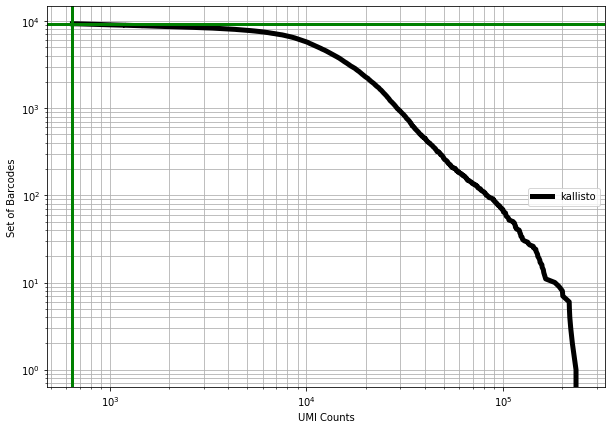

In [3]:
##############
# Knee plot #
#############
knee = np.sort((np.array(adata.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))
expected_num_cells=9276

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()

In [4]:
########################
# Analysis with ScanPy #
########################
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 9276 × 78700 
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

... storing 'feature_types' as categorical
... storing 'genome' as categorical


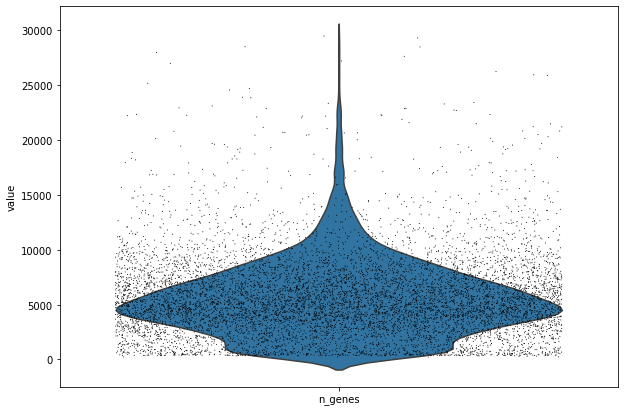

In [5]:
#########################
# Distribution of genes #
#########################
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata, 'n_genes', jitter=0.4, ax=ax)

In [6]:
######################################
# Normalize the counts in the matrix #
######################################
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata.raw = adata

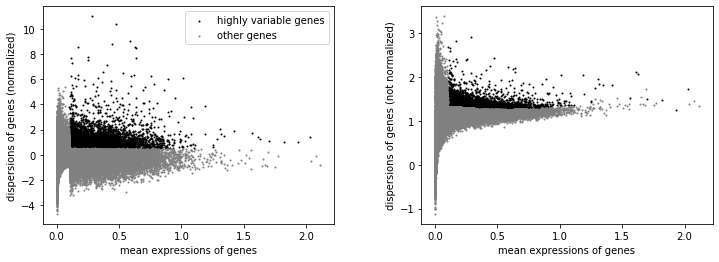

In [7]:
#########################
# Highly variable peaks #
#########################
sc.pp.highly_variable_genes(adata, min_disp=0.5, min_mean=0.1, inplace=True)
sc.pl.highly_variable_genes(adata)
adata  = adata[:, adata.var['highly_variable']]


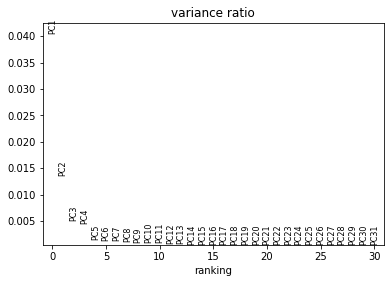

In [8]:
##########################################
# Cluster with Leiden and Plot PCA, UMAP #
##########################################
sc.pp.scale(adata)
sc.tl.pca(adata)
sc.pl.pca_variance_ratio(adata)

sc.pp.neighbors(adata, n_pcs=10)
sc.tl.umap(adata)

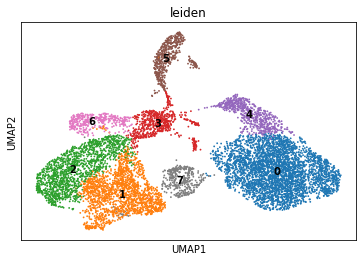

In [9]:
sc.tl.leiden(adata, resolution=0.2, random_state=0)
sc.pl.umap(adata, color='leiden', legend_loc = "on data")

In [10]:
##########################
# Finding 'marker' peaks #
##########################
sc.tl.rank_genes_groups(adata,'leiden', method='wilcoxon', n_genes=1000)

In [11]:
names = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
logFC = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])
pVals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals'])
padj = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])

In [12]:
# select significant peaks and save dataframe for each cluster
for i in range(8):
    all_sig = pd.concat([names[str(i)],logFC[str(i)],pVals[str(i)],padj[str(i)]], 
                        keys=['names','logFC','pVals','padj'], axis =1)
    all_sig = all_sig[all_sig['pVals']<=0.05]
    all_sig.to_csv('10x_top_cl_'+str(i)+'.csv',index=False)

In [13]:
################################
# DHS500 count matrix analysis #
################################
adata_dhs = sc.read("counts_hg19_dhs_merged500bp.h5ad", gex_only=False)
print(adata_dhs)

AnnData object with n_obs × n_vars = 9277 × 1040226 


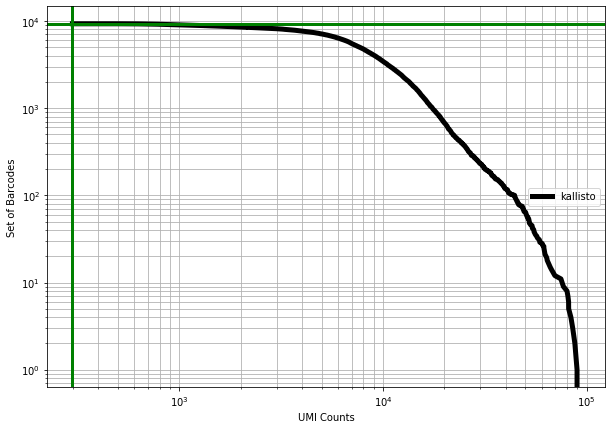

In [14]:
#############
# Knee plot #
#############
knee = np.sort((np.array(adata_dhs.X.sum(axis=1))).flatten())[::-1]

fig, ax = plt.subplots(figsize=(10, 7))
expected_num_cells=9276

ax.loglog(knee, range(len(knee)), label="kallisto", linewidth=5, color="k")
ax.axvline(x=knee[expected_num_cells], linewidth=3, color="g")
ax.axhline(y=expected_num_cells, linewidth=3, color="g")

ax.set_xlabel("UMI Counts")
ax.set_ylabel("Set of Barcodes")

plt.grid(True, which="both")
ax.legend()

In [15]:
########################
# Analysis with ScanPy #
########################
sc.pp.filter_cells(adata_dhs, min_genes=200)
sc.pp.filter_genes(adata_dhs, min_cells=10)
adata_dhs

AnnData object with n_obs × n_vars = 9277 × 336551 
    obs: 'n_genes'
    var: 'n_cells'

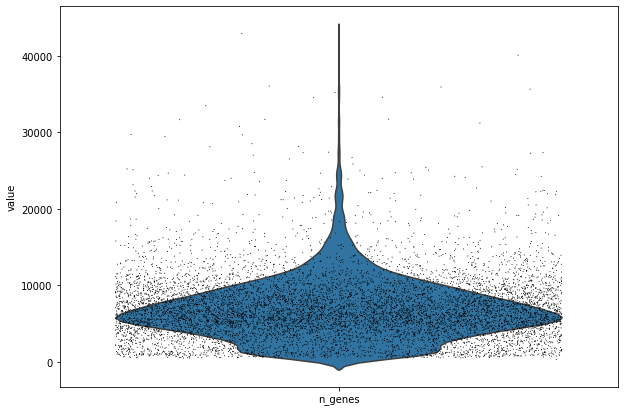

In [16]:
#########################
# Distribution of genes #
#########################
fig, ax = plt.subplots(figsize=(10, 7))
sc.pl.violin(adata_dhs, 'n_genes', jitter=0.4, ax=ax)

In [17]:
######################################
# Normalize the counts in the matrix #
######################################
sc.pp.normalize_per_cell(adata_dhs, counts_per_cell_after=1e4)
sc.pp.log1p(adata_dhs)
adata_dhs.raw = adata_dhs

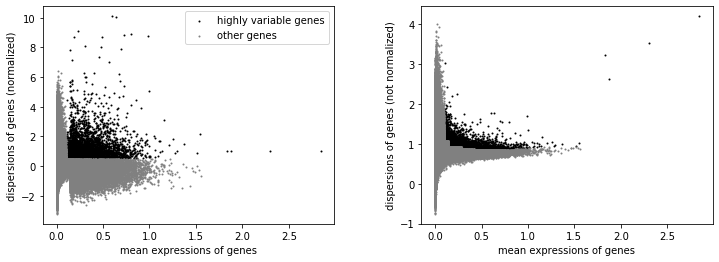

In [18]:
#########################
# Highly variable peaks #
#########################
sc.pp.highly_variable_genes(adata_dhs, min_disp=0.5, min_mean=0.1, inplace=True)
sc.pl.highly_variable_genes(adata_dhs)
adata_dhs = adata_dhs[:, adata_dhs.var['highly_variable']]

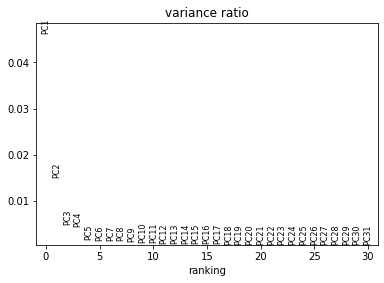

In [19]:
##########################################
# Cluster with Leiden and Plot PCA, UMAP #
##########################################
sc.pp.scale(adata_dhs)
sc.tl.pca(adata_dhs)
sc.pl.pca_variance_ratio(adata_dhs)

sc.pp.neighbors(adata_dhs, n_pcs=10)
sc.tl.umap(adata_dhs)

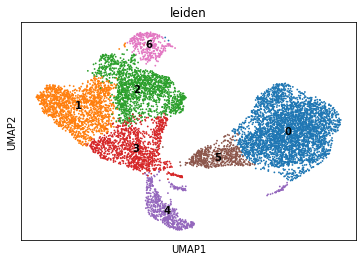

In [20]:
sc.tl.leiden(adata_dhs, resolution=0.2, random_state=0)
sc.pl.umap(adata_dhs, color='leiden', legend_loc = "on data")

In [21]:
##########################
# Finding 'marker' peaks #
##########################
sc.tl.rank_genes_groups(adata_dhs,'leiden', method='wilcoxon', n_genes=1000)

In [22]:
names = pd.DataFrame(adata_dhs.uns['rank_genes_groups']['names'])
logFC = pd.DataFrame(adata_dhs.uns['rank_genes_groups']['logfoldchanges'])
pVals = pd.DataFrame(adata_dhs.uns['rank_genes_groups']['pvals'])
padj = pd.DataFrame(adata_dhs.uns['rank_genes_groups']['pvals_adj'])

In [23]:
# select significant peaks and save dataframe for each cluster
for i in range(7):
    all_sig = pd.concat([names[str(i)],logFC[str(i)],pVals[str(i)],padj[str(i)]], 
                        keys=['names','logFC','pVals','padj'], axis =1)
    all_sig = all_sig[all_sig['pVals']<=0.05]
    all_sig.to_csv('dhs500_top_cl_'+str(i)+'.csv',index=False)

In [24]:
#############################
# Adjust Mutual Information #
#############################
cl_10x_or = adata.obs['leiden']
cl_dhs_or = adata_dhs.obs['leiden']

cl_10x_or.index = [x.split('-')[0] for x in cl_10x_or.index]

In [25]:
### this score can be evaluated only between the same set of observations 
common_cells = set(cl_10x_or.index).intersection(set(cl_dhs_or.index))

In [26]:
cl_10x = cl_10x_or.loc[common_cells]
cl_dhs = cl_dhs_or.loc[common_cells]
print("Adjust Mutual Information: ", sklearn.metrics.adjusted_mutual_info_score(cl_10x, cl_dhs))

Adjust Mutual Information:  0.7358081486530961
